In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

#Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
except:
    pass

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
ticker = 'aapl'

In [2]:
from transformers import PullData

#Initiate parameters
window_size = 25
formation_window = 24
target_window = 4

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date='2020-01-01',
            end_date='2022-08-17',
            interval='1wk',
            progress=False,
            condition=False,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path = excel_reports
            )

data_prep = GetData.transform()
print("shape: ",data_prep.shape)

####################################################################

from transformers import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=25, shuffle=False, debug=False,export_excel = False, excel_path = excel_reports)

data_normalized, Dates = NormalizeData.transform(data_prep)

####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=0.8, window_size=25, dates=Dates, debug=True)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)

shape:  (2750, 9)
Initial length of dataframe:  2750
Nr of formations:  110
New length of dataframe:  2750

Done
df:   2750
total windows in dataset:  110.0

total windows of 80.0% train set: 88.0 
total windows of 20% valid set: 22.0 

x_train window 88.0
x_valid window 22.0
Done


In [3]:
#x_valid_new = x_valid.copy()

In [4]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=25, batch_size=8, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

x_train_tensors


Done


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

In [5]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=25, batch_size=2, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)
x_valid_tensors


Done


<BatchDataset element_spec=(TensorSpec(shape=(None, 24, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

<b>Model Training</b>

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=f'{saved_models}/{ticker}_80_model_checkpoint_recent.h5',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Model 1

In [7]:
# def ModelGeneral():
# #tf.random.set_seed(7788)

#     # model = tf.keras.models.Sequential([

#     #     tf.keras.layers.Conv1D(filters=256, kernel_size=10,
#     #                     strides=1, padding="same",
#     #                     activation=tf.nn.selu,
#     #                     input_shape=[None, 7]),
#     # #     tf.keras.layers.Conv1D(filters=512, kernel_size=10,
#     # #                       strides=1, padding="same",
#     # #                       activation=tf.nn.selu,
#     # #                       input_shape=[None, 7]),

#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     # tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(4, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(3, activation=tf.nn.selu), #4
#     #     tf.keras.layers.Dense(1,activation=tf.nn.relu),
#     # ])

#     # #optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
#     # #optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#     # #optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#     # #optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

#     # optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')


#     # model.compile(loss=sign_penalty,
#     #             optimizer=optimizer5,
#     #             )

#     # model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)


Model 2

In [8]:
tf.random.set_seed(7788)
np.random.seed(7788)

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=8, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           input_shape=[None, 7]),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),
    tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),
    #tf.keras.layers.Dense(256, activation=tf.nn.selu),
    tf.keras.layers.Dense(4, activation=tf.nn.selu),
    # tf.keras.layers.Dense(4, activation=tf.nn.selu),
    # #tf.keras.layers.Dropout(0.99),
    #tf.keras.layers.Dense(3, activation=tf.nn.selu),
    # #tf.keras.layers.Dropout(0.99),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(2, activation=tf.nn.selu),        
    tf.keras.layers.Dense(1, activation=tf.nn.relu),
])

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=8, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Epoch 1/8
11/11 [==============================] - 14s 458ms/step - loss: 0.0213 - val_loss: 0.0628 - lr: 0.0050
Epoch 2/8
11/11 [==============================] - 0s 38ms/step - loss: 0.0201 - val_loss: 0.0639 - lr: 0.0050
Epoch 3/8
11/11 [==============================] - ETA: 0s - loss: 0.0193
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
11/11 [==============================] - 0s 40ms/step - loss: 0.0193 - val_loss: 0.0636 - lr: 0.0050
Epoch 4/8
11/11 [==============================] - 0s 40ms/step - loss: 0.0179 - val_loss: 0.0631 - lr: 1.0000e-03
Epoch 5/8
11/11 [==============================] - ETA: 0s - loss: 0.0178
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001999999862164259.
11/11 [==============================] - 0s 36ms/step - loss: 0.0178 - val_loss: 0.0628 - lr: 1.0000e-03
Epoch 6/8
11/11 [==============================] - 1s 51ms/step - loss: 0.0176 - val_loss: 0.0627 - lr: 2.0000e-04
Epoch 7/8
11/11 [=======================

In [9]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


22/22 [==============================] - 3s 6ms/step


array([0.9297255, 0.9366555], dtype=float32)

In [10]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)
# predict = model.predict(pred)
# print("Raw prediction: ", predict)


In [11]:
from transformers import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=25, debug=False)

df = ReverseNormalization.transform()
df.shape

Done


(550, 9)

In [12]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid)

reversed_df = GetFinalDataframe.transform(df)
#df1.head(25)


Done


In [13]:
from final_evaluation import GetModelPerformance

GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=25,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df.shape


period: 2021-09-06 - 2022-07-11
Formations:  22
Entry Candle:  Current Open

Total Trades:  22
Profit Trades:  10
Loss Trades:  12

Win Ratio: 45.0 %
Loss Ratio: 55 %

Average profit per trade:  421

Gross profit:  9269
Gross loss:  -7941

Net profit:  1328


In [14]:
trade = 1
budget = 10000
entry_candle = 'Current Open'

Trade:  1
Period: 2021-09-06 - 2022-02-14

Budget:  10000

Entry price:  164.98
Label (target):  168.91
Model prediction:  179.8
Market Change: -1.0 $
Profit: -60.61 $


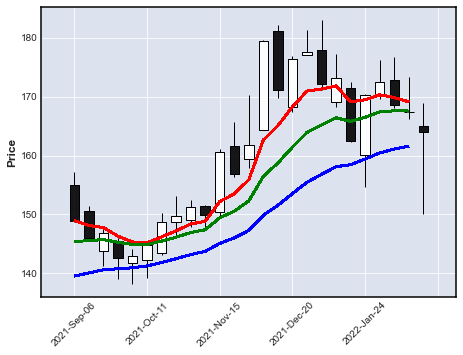

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
0,154.970001,157.259995,148.699997,148.970001,148.978732,145.446614,139.562798,nn,nn,2021-09-06,-1.0,1
1,150.630005,151.419998,145.759995,146.059998,148.144808,145.540981,140.082574,nn,nn,2021-09-13,-1.0,1
2,143.800003,147.470001,141.270004,146.919998,147.794862,145.753137,140.629568,nn,nn,2021-09-20,-1.0,1
3,145.470001,145.960007,139.110001,142.649994,146.324900,145.275730,140.791202,nn,nn,2021-09-27,-1.0,1
4,141.759995,144.220001,138.270004,142.899994,145.346355,144.910233,140.959905,nn,nn,2021-10-04,-1.0,1
5,142.270004,144.899994,139.199997,144.839996,145.201681,144.899427,141.270313,nn,nn,2021-10-11,-1.0,1
6,143.449997,150.179993,143.160004,148.690002,146.198344,145.482592,141.863888,nn,nn,2021-10-18,-1.0,1
7,148.679993,153.169998,146.410004,149.800003,147.227390,146.146809,142.498777,nn,nn,2021-10-25,-1.0,1
8,148.990005,152.429993,147.800003,151.279999,148.385278,146.936531,143.201275,nn,nn,2021-11-01,-1.0,1


In [15]:
#trade = 232
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,budget=budget)
trade += 1
df


In [16]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=25,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


Done


,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade,Entry,Performance
0,154.970001,157.259995,148.699997,148.970001,148.978732,145.446614,139.562798,nn,nn,2021-09-06,-1.000000,1,nn,nn
1,150.630005,151.419998,145.759995,146.059998,148.144808,145.540981,140.082574,nn,nn,2021-09-13,-1.000000,1,nn,nn
2,143.800003,147.470001,141.270004,146.919998,147.794862,145.753137,140.629568,nn,nn,2021-09-20,-1.000000,1,nn,nn
3,145.470001,145.960007,139.110001,142.649994,146.324900,145.275730,140.791202,nn,nn,2021-09-27,-1.000000,1,nn,nn
4,141.759995,144.220001,138.270004,142.899994,145.346355,144.910233,140.959905,nn,nn,2021-10-04,-1.000000,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,133.419998,141.910004,133.320007,141.660004,141.834333,147.788278,153.248825,nn,nn,2022-06-20,11.091676,22,nn,nn
546,142.699997,143.490005,133.770004,138.929993,141.004521,146.425465,152.103319,nn,nn,2022-06-27,11.091676,22,nn,nn
547,137.770004,147.550003,136.929993,147.039993,142.728942,146.520008,151.698253,nn,nn,2022-07-04,11.091676,22,nn,nn
548,145.669998,150.860001,142.119995,150.169998,144.854958,147.081545,151.575992,nn,nn,2022-07-11,11.091676,22,nn,nn


In [17]:
#import tensorflow as tf
from final_evaluation import MakeSinglePrediction

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=f'{saved_models}/{ticker}_80_model_checkpoint_recent.h5',
                        form_window=24,
                        ticker='aapl',
                        start_date="2021-03-18",
                        end_date="2022-08-13",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Close')

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]

###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

MakeSinglePrediction.transform(trade_formation)



1/1 [==============================] - 2s 2s/step

Entry candle (Current Close)

Prediction is NOT profitable

Entry price:  172.1
Max Prediction:  169.32


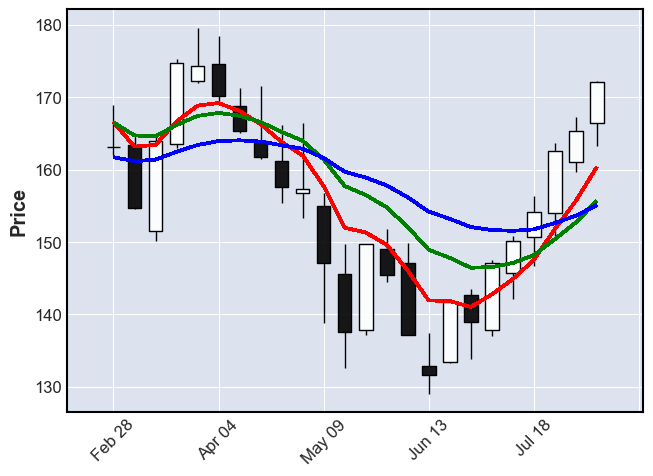

In [18]:
from plotting import PlotCurrentFormation

PlotCurrentFormation(trade_formation)

In [19]:
trade_formation

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
50,2022-02-28,163.059998,168.910004,161.970001,163.169998,166.539455,166.518114,161.702975
51,2022-03-07,163.360001,165.020004,154.500000,154.729996,163.165324,164.704558,161.145137
52,2022-03-14,151.449997,164.479996,150.100006,163.979996,163.398087,164.593087,161.371926
53,2022-03-21,163.509995,175.279999,163.009995,174.720001,166.632920,166.151074,162.439772
54,2022-03-28,172.169998,179.610001,171.940002,174.309998,168.826370,167.406293,163.389390
55,2022-04-04,174.570007,178.490005,169.199997,170.089996,169.187406,167.819170,163.925438
56,2022-04-11,168.710007,171.270004,165.039993,165.289993,168.073860,167.430066,164.034603
57,2022-04-18,163.919998,171.529999,161.500000,161.789993,166.278469,166.562362,163.855034
58,2022-04-25,161.119995,166.199997,155.380005,157.649994,163.813191,165.191229,163.358631
59,2022-05-02,156.710007,166.479996,153.270004,157.279999,161.946564,163.974117,162.872340
